In [2]:
import os
import glob
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import scipy

In [93]:
tf.random.set_seed(42)
files = glob.glob(os.path.join('train/', '*/*'))
stars = []
for file in files:
    file_name = file.split('\\')[1]
    stars.append(file_name)
stars = np.unique(stars)

import random
random.seed(42)

def split_star_list(file_list, test_ratio=0.6):
    random.shuffle(file_list)
    split_index = int(len(file_list) * (1 - test_ratio))
    train_files = file_list[:split_index]
    test_files = file_list[split_index:]
    return train_files, test_files

train_stars, test_stars = split_star_list(stars)

labelDf = pd.read_csv("train_labels.csv")
labelDf = labelDf.set_index('planet_id')
meanLabels = np.mean(labelDf.mean())
stdLabels = np.std(labelDf.std())
maxLabels = np.max(labelDf.max())
minLabels = np.min(labelDf.min())

trainLabels = labelDf.loc[[int(star) for star in train_stars]]
meanTrainLabels = np.mean(trainLabels.mean())
stdTrainLabels = np.std(trainLabels.std())
maxTrainLabels = np.max(trainLabels.max())
minTrainLabels = np.min(trainLabels.min())

for col in labelDf.columns:
    labelDf.loc[:,col] = (labelDf[col]) / (maxTrainLabels)

# normalize over time and all samples, so we have a mean and a std dev per wavelength for all samples
def calcMeanAndStdOfTrain(train_stars):
    i = 0
    for star in train_stars:
        file_path = 'train/'+str(star)+'/combined.npz'
        with np.load(file_path) as data:
            x = data['a'][0,:,0:283,:]
            if i ==0:
                mean = np.mean(x,axis=(0))
                sumS = np.sum(x**2,axis=0)
            else:
                mean = mean + np.mean(x, axis=(0))
                sumS += np.sum(x**2,axis=0)
            i=i+1
    meanTrain = mean / i
    stdTrain = np.sqrt(sumS / (i*x.shape[0]) - meanTrain**2)    
    return meanTrain, stdTrain
#meanTrain, stdTrain = calcMeanAndStdOfTrain(train_stars)

def normalize_over_train(features, labels):
    features = (features - meanTrain) / (stdTrain + 1e-6)
    return features, labels

# normalize over time per samples, so we have a mean and a std dev per wavelength for all samples
def calcMeanAndStdOfTrainPerStar(x):
    mean = np.mean(x,axis=(0))
    sumS = np.sum(x**2,axis=0)
    stdTrain = np.sqrt(sumS / (x.shape[0]) - mean**2)    
    return mean, stdTrain
def normalize_per_sample(features, labels):
    m,s = calcMeanAndStdOfTrainPerStar(features)
    features = (features) / (s + 1e-6)
    return features, labels




def load_npz(star):
    integer_value = tf.strings.to_number(star, out_type=tf.int64)
    python_int = integer_value.numpy()

    file_path = 'train/'+str(python_int)+'/combined.npz'
    try:
        with np.load(file_path) as data:
            features = data['a'][0,:,0:283,:]
            labels = labelDf.loc[python_int].to_numpy()
            features = np.reshape(features,(-1,25,283,4))
            features = np.mean(features,axis=1)
            #features, labels = normalize_per_sample(features,labels)
            #features, labels = normalize_over_train(features,labels)
            return features, labels
    except Exception as e:
        print("Error loading file:", e, python_int)
    

def create_dataset(star_list, batch_size, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices(star_list)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(star_list))
    def load_and_process(x):
        features, labels = tf.py_function(
            func=load_npz,
            inp=[x],
            Tout=[tf.float64, tf.float32]
        )
        return features, labels

    dataset = dataset.map(load_and_process, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(lambda x, y: (tf.ensure_shape(x,tf.TensorShape([225, 283, 4])), tf.ensure_shape(y, tf.TensorShape([283])))) #5625
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


In [94]:
tf.random.set_seed(42)
batch_size = 64

train_dataset = create_dataset(train_stars, batch_size, shuffle=True)
test_dataset = create_dataset(test_stars, batch_size, shuffle=False)

In [95]:
for x,y in test_dataset:
    print(x.shape,y.shape)
    break

(64, 225, 283, 4) (64, 283)


In [97]:
np.mean(x,axis=2).shape

(64, 225, 4)

# k-means for mean

In [120]:
import os
os.environ['OMP_NUM_THREADS'] = '1'
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

def predictWKMeans(x):
    out=np.zeros(x.shape[0])
    x = np.mean(x,axis=2)[:,:,1]
    for i in range(x.shape[0]):
        d = x[i,:].reshape(-1,1)
        kmeans = KMeans(n_clusters=2, random_state=0,n_init=2)
        clusters = kmeans.fit_predict(d)
        
        y1 = np.mean(d[clusters == 0])
        y2 = np.mean(d[clusters == 1])
        out[i] = abs(y1-y2)/y2
        #print(y1,y2,abs(y1-y2)/y2,y[i]*maxLabels)
    return out

for x,y in train_dataset:
    out = predictWKMeans(x)
    gt = np.mean(y,axis=1)*maxLabels
    print(sum(np.abs((out-gt)**2)) / len(out), (np.sum(np.abs(out-gt))) / len(out))#,out.shape,gt.shape

1.1297929953105912e-07 0.00026475968716705605
1.0061496385367653e-07 0.00022508150917603887
1.6418349902901463e-07 0.00032002158309398366
9.690532831121264e-08 0.00025184297501776114
1.2439616258802237e-07 0.00024989602572010405


In [121]:
for x,y in test_dataset:
    out = predictWKMeans(x)
    gt = np.mean(y,axis=1)*maxLabels
    print(sum(np.abs((out-gt)**2)) / len(out), (np.sum(np.abs(out-gt))) / len(out))#,out.shape,gt.shape

1.3554100844723598e-07 0.0002808796576521868
1.7613590324651584e-07 0.0002695729513781918
1.2416090555513726e-07 0.00026247273750707963
8.801910242431091e-08 0.0002363003426927812
1.3291411356522793e-07 0.0002864066801152278
1.0959346099036087e-07 0.00023872416110020335
1.1818372513108808e-07 0.0002415301370899291


In [123]:
0.01*maxTrainLabels

7.991950516971699e-05

In [127]:
(1*283*64)**2

328044544

67635.6838405694 67765.70303962422 0.0019186578641232994 tf.Tensor([0.00191344], shape=(1,), dtype=float32)


c:\Users\uic33116\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


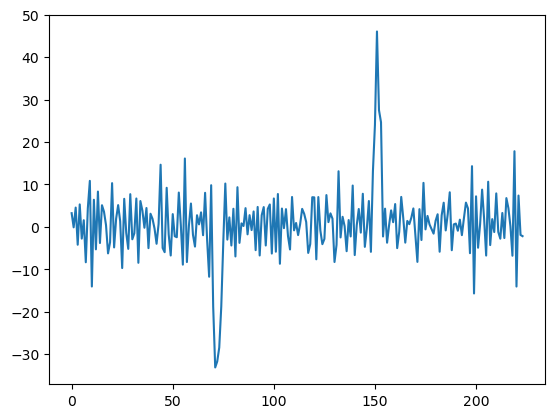

In [80]:
i = 4
d = x[i,:].numpy().reshape(-1,1)
fig = plt.figure()
#plt.plot(d)
plt.plot(np.diff(d[:,0]))

kmeans = KMeans(n_clusters=2, random_state=0)
clusters = kmeans.fit_predict(d)

y1 = np.mean(d[clusters == 0])
y2 = np.mean(d[clusters == 1])
print(y1,y2,abs(y1-y2)/y2,y[i]*maxLabels)
#plt.plot(range(283),y1*np.ones(283))
#plt.plot(range(283),y2*np.ones(283))
plt.show()

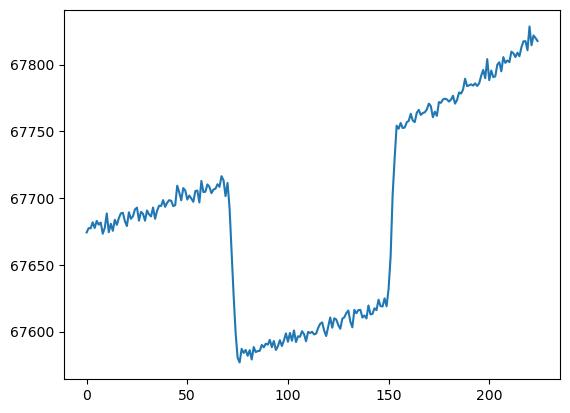

In [81]:
plt.plot(d)

# k means for everything

5853.671958837936 5811.30626277233 0.007290219126292346 tf.Tensor(0.0018577672, shape=(), dtype=float32)


c:\Users\uic33116\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


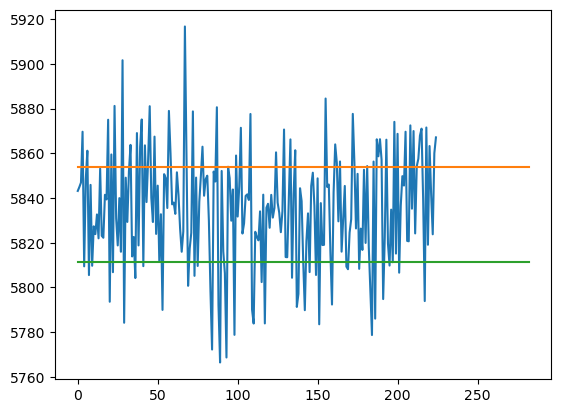

In [92]:
i = 4
waveL = 1
d = x[i,:,waveL,1].numpy().reshape(-1,1)
fig = plt.figure()
plt.plot(d)
#plt.plot(np.diff(d[:,0]))

kmeans = KMeans(n_clusters=2, random_state=0)
clusters = kmeans.fit_predict(d)

y1 = np.mean(d[clusters == 0])
y2 = np.mean(d[clusters == 1])
print(y1,y2,abs(y1-y2)/y2,y[i,waveL]*maxLabels)
plt.plot(range(283),y1*np.ones(283))
plt.plot(range(283),y2*np.ones(283))
plt.show()